# Chapter3. 분류

## MNIST

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1, as_frame = True)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']
print(X.shape, y.shape)

(70000, 784) (70000,)


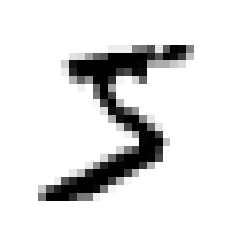

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

some_digit = np.array(X.iloc[0])
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = 'binary')
plt.axis('off')
plt.show()

In [4]:
y = y.astype(np.uint8)

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

### SGD Classifier
- 확률적 경사 하강법(Stochastic Gradient Descent, SGD)

In [6]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [7]:
sgd_clf.predict([some_digit])

C:\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

## 성능 측정

In [44]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# fold를 3으로 지정했기 때문에 3번 검사한다.
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

# fold = 3 이므로 train_index와 test_index는 3번 입력된다.
# 여기서 각 index의 형태는 [    1     3     4 ... 59994 59996 59998] 이러하다.
for train_index, test_index in skfolds.split(X_train, y_train_5):   
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index, :]
    y_train_folds = y_train_5.loc[train_index]
    X_test_fold = X_train.iloc[test_index, :]
    y_test_fold = y_train_5.loc[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [45]:
from sklearn.model_selection import cross_val_score

# cross_val_score(분류기 객체, X훈련세트, y 훈련세트, cv = 횟수, 점수 산정 방식 = '')
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.95466667, 0.96975   , 0.9635    , 0.96533333, 0.94841667])

In [46]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self

    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

In [47]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.91125, 0.90855, 0.90915])

### 오차 행렬(Confusion Matrix)

In [48]:
from sklearn.model_selection import cross_val_predict

# cross_val_predict는 cross_val_score() 함수처럼 k-겹 교차 검증을 수행하지만 평가 점수를 반환하지 않고
# 각 테스트 폴드에서 얻은 예측을 반환한다.
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

# 약간 1종오류, 2종오류 공부할 때와 비슷하게 이해하면 된다!
# array([[53892,   687], (Negative class): 53892개를 '5 아님'으로 정확히 분류했고(true negative) 
# 687개를 5로 잘못 분류했음(false positive).
#        [ 1891,  3530]], dtype=int64) (Positive class): 1891개를 5아님으로 잘못 분류했고(false negative),
#  3530개를 정확히 5라고 분류한 것(true positive)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [49]:
y_train_perfect_predicions = y_train_5 # 완벽한 분류기일 경우
confusion_matrix(y_train_5, y_train_perfect_predicions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### 정밀도
: 양성이라고 예측한 것들 중 진짜 양성인 경우
$ 정밀도 = {TP \over {TP + FP}} $
- TP는 진짜 양성의 수
- FP는 거짓 양성의 수

### 재현율(민감도, TPR)
: 실제 양성인 것들 중에서 양성이라고 예측할 확률
$ 재현율 = {TP \over {TP + FN}} $
- FN은 거짓 음성의 수

In [51]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # 정밀도
# 3530 / (3530 + 687)

recall_score(y_train_5, y_train_pred) # 재현율
# 3530/ (3530 + 1891)

0.6511713705958311

### $ F_1 점수 $
- 정밀도와 재현율의 조화 평균

$ F_1 = {2 \over {{1 \over {정밀도}} + {1 \over {재현율}}}} = 2 ×{{정밀도 × 재현율} \over {정밀도 + 재현율}} = 
{TP \over {TP + {{FN + FP} \over 2}}} $

In [52]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846